In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


# Bayesian LASSO

In [2]:
n = 50
k = 100

np.random.seed(1234)
X = np.random.normal(size=(n, k))

beta = np.zeros(shape=k)
beta[[10,30,50,70]] =  10
beta[[20,40,60,80]] = -10

y = X @ beta + np.random.normal(size=n)

## Weakly informative prior

In [3]:
with pm.Model() as bayes_weak:
    b = pm.Normal('beta', mu=0, sigma=10, shape=k)
    y_est = X @ b
    s = pm.HalfNormal('sigma', sd=2)
    y_ = pm.Normal('y', mu=y_est, sigma=1, observed=y)

In [4]:
with bayes_weak:
    trace = pm.sample(return_inferencedata=True, random_seed=12345)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 181 seconds.


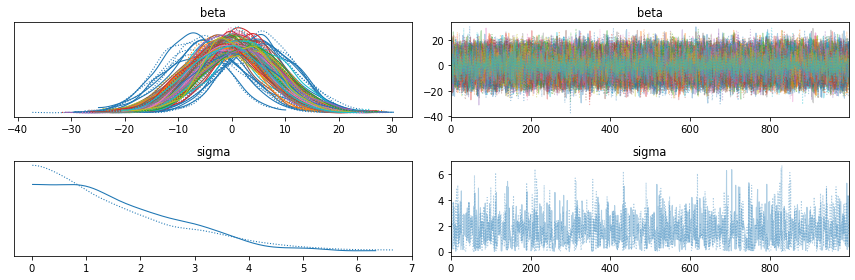

In [5]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [6]:
post = (
    trace.posterior['beta']
    .to_dataframe()
    .reset_index()
    .query('chain == 0')
)
print(post)

       chain  draw  beta_dim_0       beta
0          0     0           0  10.397492
1          0     0           1   2.929798
2          0     0           2 -11.164498
3          0     0           3  -7.415240
4          0     0           4   2.265279
...      ...   ...         ...        ...
99995      0   999          95  -4.903119
99996      0   999          96   4.915649
99997      0   999          97  -4.820775
99998      0   999          98  -2.739976
99999      0   999          99  -6.006542

[100000 rows x 4 columns]


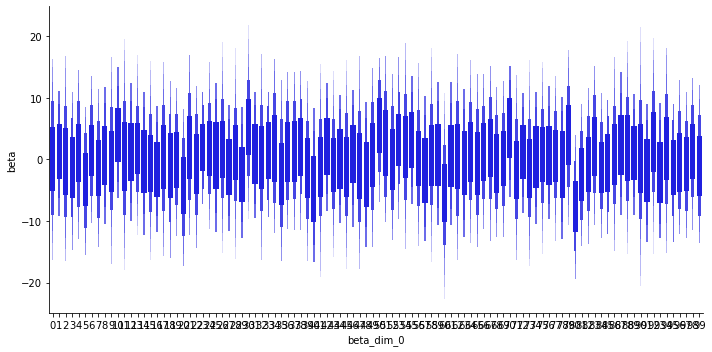

In [7]:
sns.catplot(
    x='beta_dim_0',
    y='beta',
    data=post,
    kind='boxen',
    linewidth=0,
    color='blue',
    aspect=2,
    showfliers=False
)
plt.show()

In [8]:
with pm.Model() as bayes_lasso:
    b = pm.Laplace('beta', 0, 1, shape=k)
    y_est = X @ b
    s = pm.HalfNormal('sigma', sd=2)
    y_ = pm.Normal('y', mu=y_est, sigma=1, observed=y)

In [9]:
with bayes_lasso:
    trace = pm.sample(return_inferencedata=True, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 41 seconds.


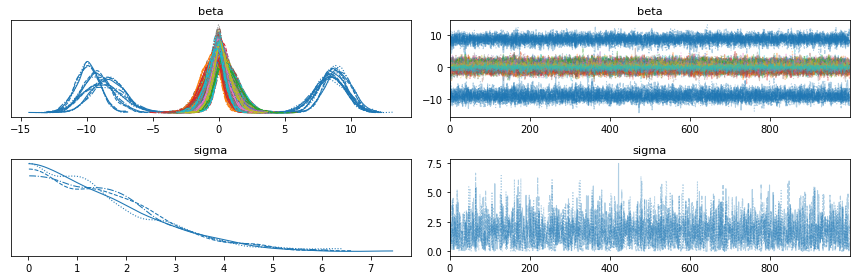

In [26]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [27]:
post = (
    trace.posterior['beta']
    .to_dataframe()
    .reset_index()
    .query('chain == 0')
)
print(post)

       chain  draw  beta_dim_0      beta
0          0     0           0 -0.932015
1          0     0           1 -0.037876
2          0     0           2  0.259595
3          0     0           3 -0.540260
4          0     0           4 -0.281143
...      ...   ...         ...       ...
99995      0   999          95 -0.758283
99996      0   999          96 -0.125862
99997      0   999          97  0.181229
99998      0   999          98  0.062365
99999      0   999          99 -1.332659

[100000 rows x 4 columns]


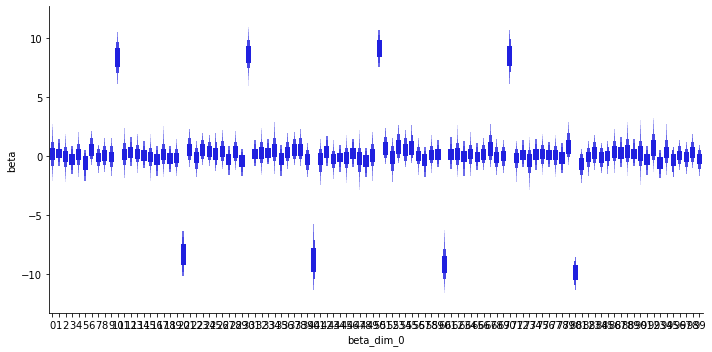

In [28]:
sns.catplot(
    x='beta_dim_0',
    y='beta',
    data=post,
    kind='boxen',
    linewidth=0,
    color='blue',
    aspect=2,
    showfliers=False
)
plt.show()

## Demo 2 - Gaussian Process

ExpQuad covariance function:

$\qquad k(x, x') = \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right]$

In [29]:
np.random.seed(12345)

n = 50
x = np.linspace(0, 1, n)
X = x.reshape(-1,1)

nugget = 0.75
sigma2_true = 4.0
l_true = 10

cov_func = sigma2_true * pm.gp.cov.ExpQuad(1, 1/l_true)
mean_func = pm.gp.mean.Zero()

y_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval(), 1
).flatten()

y = y_true + nugget * np.random.randn(n)

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(x, y)

In [30]:
D = np.array([np.abs(x1 - x) for x1 in x])
D0 = (D==0).astype('double')

In [ ]:
with pm.Model() as gp:
    nugget = pm.HalfCauchy('nugget', beta=5)
    sigma2 = pm.HalfCauchy('sigma2', beta=5)
    inv_l = pm.HalfCauchy('inv_l', beta=5)
    
    Sigma = D0*nugget + sigma2*np.exp(-0.5 * D**2 * inv_l**2)
    
    y_ = pm.MvNormal('y', mu=np.zeros(n), cov=Sigma, observed=y)
    
with gp:
    trace = pm.sample(
        return_inferencedata=True,
        chains=2
    )

In [39]:
with gp:
    trace_nuts = pm.sample(
        return_inferencedata=True,
        chains=2
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [inv_l, sigma2, nugget]


ValueError: Not enough samples to build a trace.

In [33]:
with gp:
    step = pm.Metropolis([nugget, sigma2, inv_l])
    
    trace_mh = pm.sample(
        return_inferencedata=True,
        chains=2,
        step=step
    )

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [inv_l]
>Metropolis: [sigma2]
>Metropolis: [nugget]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [34]:
with gp:
    step = pm.Slice([nugget, sigma2, inv_l])
    
    trace_slice = pm.sample(
        return_inferencedata=True,
        chains=2,
        step=step
    )

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Slice: [inv_l]
>Slice: [sigma2]
>Slice: [nugget]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [ ]:
az.plot_trace(trace_nuts)

array([[<AxesSubplot:title={'center':'nugget'}>,
        <AxesSubplot:title={'center':'nugget'}>],
       [<AxesSubplot:title={'center':'sigma2'}>,
        <AxesSubplot:title={'center':'sigma2'}>],
       [<AxesSubplot:title={'center':'inv_l'}>,
        <AxesSubplot:title={'center':'inv_l'}>]], dtype=object)

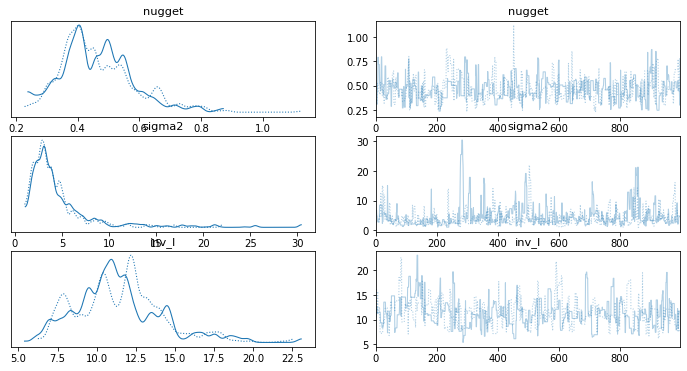

In [35]:
az.plot_trace(trace_mh)

array([[<AxesSubplot:title={'center':'nugget'}>,
        <AxesSubplot:title={'center':'nugget'}>],
       [<AxesSubplot:title={'center':'sigma2'}>,
        <AxesSubplot:title={'center':'sigma2'}>],
       [<AxesSubplot:title={'center':'inv_l'}>,
        <AxesSubplot:title={'center':'inv_l'}>]], dtype=object)

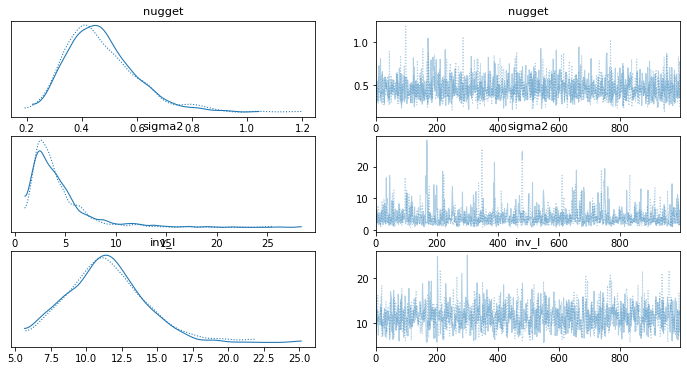

In [36]:
az.plot_trace(trace_slice)

In [37]:
az.summary(trace_mh)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nugget,0.464,0.118,0.248,0.674,0.007,0.005,307.0,286.0,1.00
sigma2,4.421,3.358,1.011,9.554,0.240,0.170,166.0,278.0,1.01
inv_l,11.430,2.741,6.942,16.995,0.226,0.161,151.0,215.0,1.00


In [38]:
az.summary(trace_slice)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nugget,0.471,0.128,0.247,0.703,0.003,0.002,1765.0,1144.0,1.0
sigma2,4.208,2.864,1.003,8.857,0.094,0.068,1155.0,1157.0,1.0
inv_l,11.414,2.706,6.317,15.998,0.083,0.059,1071.0,1118.0,1.0


In [ ]:
az.summary(trace)

In [40]:
## PyMC Marginal GP Implementation

In [44]:
with pm.Model() as gp_marginal:
    nugget = pm.HalfCauchy('nugget', beta=5)
    sigma2 = pm.HalfCauchy('sigma2', beta=5)
    inv_l = pm.HalfCauchy('inv_l', beta=5)
    
    cov = sigma2 * pm.gp.cov.ExpQuad(input_dim=1, ls=1/inv_l)
    gp = pm.gp.Marginal(cov_func=cov)
    
    # X,y must be NumPy arrays
    y_ = gp.marginal_likelihood('y', X, y, noise=nugget)

In [46]:
with gp_marginal:
    step = pm.Slice([nugget, sigma2, inv_l])
    
    trace = pm.sample(
        return_inferencedata=True,
        chains=2,
        step=step
    )

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Slice: [inv_l]
>Slice: [sigma2]
>Slice: [nugget]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


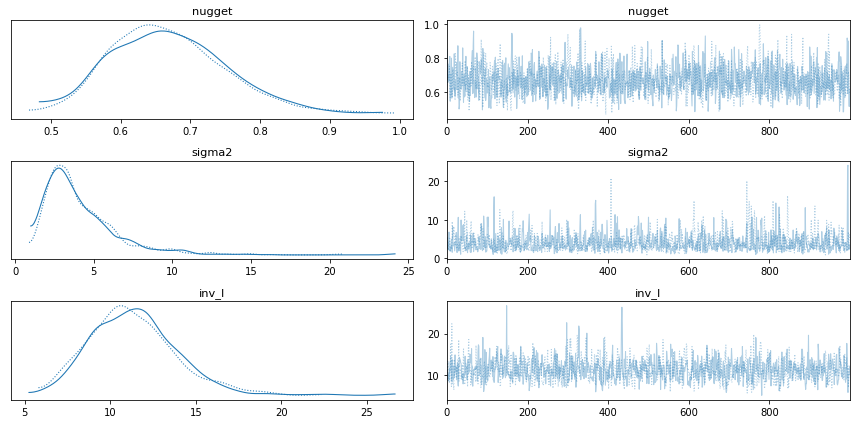

In [49]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [53]:
with gp_marginal:
    mp = pm.find_MAP()

print(mp)


{'nugget_log__': array(-0.45875172), 'sigma2_log__': array(1.00497223), 'inv_l_log__': array(2.46349202), 'nugget': array(0.63207215), 'sigma2': array(2.73183142), 'inv_l': array(11.74575643)}


In [54]:
X_pred = np.linspace(0, 1, 1000).reshape(-1, 1)
with gp_marginal:
    y_pred = gp.conditional('y_pred', X_pred)

In [56]:
with gp_marginal:
    pp_trace = pm.sample_posterior_predictive([trace], var_names=['y_pred'], samples=100)

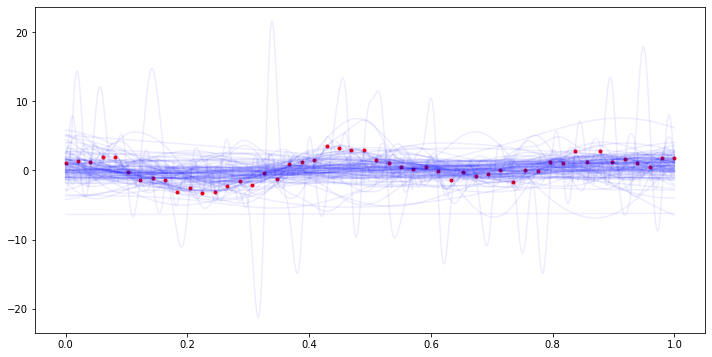

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(x, y, '.r')
plt.plot(X_pred, pp_trace['y_pred'].T, '-b', alpha=0.07)
plt.show()

It is completely bugged, the new version for PyMC will fix it.

In [61]:
with gp_marginal:
    pp_mp = pm.sample_posterior_predictive([mp], var_names=['y_pred'], samples=500)

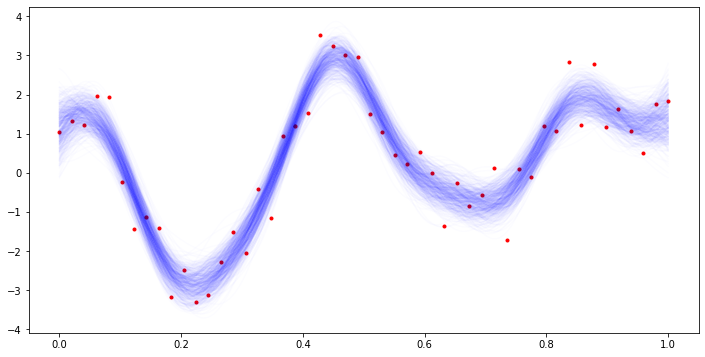

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(x, y, '.r')
plt.plot(X_pred, pp_mp['y_pred'].T, '-b', alpha=0.01)
plt.show()

In [68]:
res = []
for i in range(500):
    test = {
        'nugget': trace.posterior['nugget'].values[0, i],
        'sigma2': trace.posterior['sigma2'].values[0, i],
        'inv_l': trace.posterior['inv_l'].values[0, i],
    }
    
    with gp_marginal:
        pp_test = pm.sample_posterior_predictive(
            [test], var_names=['y_pred'], samples=1, progressbar=False
        )
        
    res.append(pp_test['y_pred'])
    
res = np.array(res).reshape(500, -1)

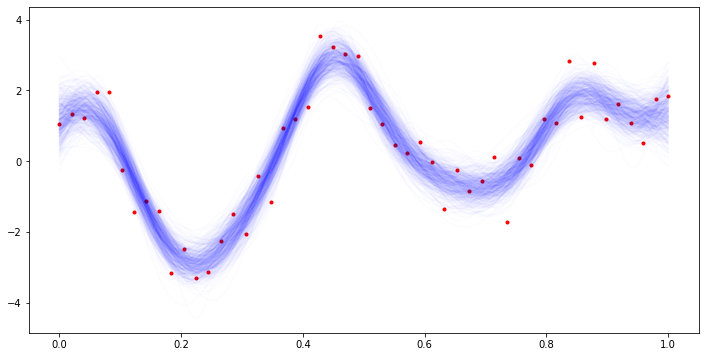

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(x, y, '.r')
plt.plot(X_pred, res.T, '-b', alpha=0.01)
plt.show()